In [522]:
using DataFrames, CSV
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots, GRUtils
using Distributions
using Gurobi, JuMP

In [523]:
# Data
data = Matrix(DataFrame(CSV.File("../data/demand.csv")));

# Constants
N = round(Int, (size(data)[1] - 2) / 2)    # number of trips
K = 2 ;                                    # number of shuttles

# Splitting the data into sublists
q = data[1:2*N+2, 4];
d = data[1:2*N+2, 5];
e = data[1:2*N+2, 7];
l = data[1:2*N+2, 8];

#### The cost matrix

We need to compute the cost matrix t[i,j]. For the moment, we know the cost matrix t[i,j] where i and j are origin-destination pairs. As a recall, we have selected 19 possible origins and 45 possible destinations. As our model here includes 99 trips, our current formulation gives: t[i,j] could be t[67,97] which of course leads to an error. Therefore, we should find a way to compute the cost matrix t[i,j] for each trip.

In [524]:
data

40×9 Matrix{Any}:
  0  42.3638  -71.0886   0  0.0    0.0       0.0     1000.0     "Depot"
  1  42.3568  -71.0957   1  0.5  139.131   134.131    144.131   "Baker House"
  2  42.3621  -71.0854   1  0.5  105.905   100.905    110.905   "Graduate Tower"
  3  42.3601  -71.098    1  0.5  110.614   105.614    115.614   "Edgerton House"
  4  42.3578  -71.0934   1  0.5  126.257   121.257    131.257   "Maseeh Hall"
  5  42.362   -71.0983   1  0.5  116.065   111.065    121.065   "Random Hall"
  6  42.3599  -71.102    1  0.5   89.8991   84.8991    94.8991  "Sidney-Pacific"
  7  42.362   -71.0983   1  0.5  153.391   148.391    158.391   "Random Hall"
  8  42.36    -71.0884   1  0.5  112.091   107.091    117.091   "East Campus"
  9  42.3592  -71.0976   1  0.5  117.261   112.261    122.261   "New Vassar"
 10  42.3553  -71.1006   1  0.5  114.353   109.353    119.353   "New House"
 11  42.3601  -71.087    1  0.5  117.198   112.198    122.198   "70 Amherst Street"
 12  42.3601  -71.087    1  0.5  103.219

In [525]:
# Use this cost later to load costs from BingsMap. For now, we will simply use the euclidian distance as shown below.
driving_times = DataFrame(CSV.File("../data/OR_Full_Times.csv"));
origins_names = driving_times[:,1]
destinations_names = names(driving_times)[2:end];
driving_times = Matrix(driving_times)[:,2:end];

# Let's construct the matrix t[i,j]
t = zeros(2*N+2, 2*N+2)

# Create a dictionary
origin_dict = Dict(zip(origins_names,1:length(origins_names)));
destination_dict = Dict(zip(destinations_names,1:length(destinations_names)));


for i in 1:2*N+2
    for j in 1:2*N+2

        orr = data[i,9]
        des = data[j,9]

        # find the index of orr in origins_names
        # orr_index = findfirst(x -> x == orr, origins_names)
        # des_index = findfirst(x -> x == des, destinations_names)

        orr_index = origin_dict[orr]
        des_index = destination_dict[des]

        t[i,j] = driving_times[orr_index, des_index]
    end 
end 

c = t ; #let's consider in this initial model that the travel cost and the time and equivalent. 

### The model

In [526]:
model = Model(Gurobi.Optimizer)

V =  1:2*N+2                    # all vertices
P = 2:N+1                       # pick up vertices
D = N+2:2*N+1                   # drop off vertices
PUD = 2:2*N+1                   # all pick up and drop off vertices together (all vertices except depot)

T = fill(1000, K)                # maximum duration of route k
L = 1000                         # maximum time of a drive
Q = fill(20, K)                # capacity of each car

# Variables
@variable(model, x[1:2*N+2, 1:2*N+2, 1:K] >= 0, Bin)   # x[i, j, k] = 1 if we go from node i to node j with vehicle k.
@variable(model, w[1:2*N+2, 1:K] >= 0, Int)            # w[i,k] load of vehicle k when arriving upon leaving vertex i
@variable(model, r[1:N] >= 0)                          # r[i,k] travel time of passenger i (Note that passenger i is identified by) the vertex i+1
@variable(model, u[1:2*N+2, 1:K] >= 0)                 # u[i,k] time as which the vertex i is served by vehicle k

#############  Constraints  #############

# only one car can bring passenger {i, i+N} to its final destination.
@constraint(model, [i in P], sum(sum(x[i, j, k] for j in V) for k = 1:K) == 1)

# each vehicle starts at the depot
@constraint(model, [k = 1:K], sum(x[1, j, k] for j in V) == 1)

# each vehicle ends at the depot
@constraint(model, [k = 1:K], sum(x[i, 2*N+2, k] for i in V) == 1)

# each passenger is picked and droped by the same car
@constraint(model, [i in P, k = 1:K], sum(x[i, j, k] for j in V) - sum(x[i+N, j, k] for j in V) == 0)

# vehicle k follows the edges sequentially
@constraint(model, [i in PUD, k = 1:K], sum(x[j, i, k] for j in V) - sum(x[i, j, k] for j in V) == 0)

# PREVIOUS the time served of vertex i
@constraint(model, [i in V, j in V, k = 1:K], u[j, k] >= (u[i, k] + d[i] + t[i, j]) * x[i, j, k])

# updating the load of the vehicle
@constraint(model, [i in V, j in V, k = 1:K], w[j, k] >= (w[i, k] + q[j]) * x[i, j, k])

# updating the travel time of passenger i
@constraint(model, [i in P, k = 1:K], r[i-1] == u[N+i, k] - (u[i, k] + d[i]))

# respecting the total length of a trip
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] >= 0) # NEW
@constraint(model, [k = 1:K], u[2*N+2,k] - u[1,k] <= T[k])

# respecting travel window of passenger i
@constraint(model, [i in V, k = 1:K], e[i] <= u[i,k])
@constraint(model, [i in V, k = 1:K], u[i,k] <= l[i])

# respecting travel window of passenger i
@constraint(model, [i in P], t[i,i+N] <= r[i-1])
@constraint(model, [i in P], r[i-1] <= L)

# respecting each car's capacity
@constraint(model, [i in V, k = 1:K], max(0, q[i]) <= w[i, k])
@constraint(model, [i in V, k = 1:K], w[i, k] <= min(Q[k], Q[k] + q[i]))

# objective
@objective(model, Min, sum(sum(sum(c[i, j] * x[i, j, k] for k = 1:K) for i in V) for j in V));

Set parameter Username
Academic license - for non-commercial use only - expires 2023-08-17


In [527]:
optimize!(model)

In [ ]:
x_values = value.(x)

30×30×2 Array{Float64, 3}:
[:, :, 1] =
  0.0   1.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   0.0
 -0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   1.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0   0.0   0.0   0.0   0.0   0.0  -0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  -0.0   0.0   0.0   0.0   0.0   0.0   0.0  -0.0   0.0   0.0   0.0   0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0  -0.0  -0.0   0.0  -0.0   0.0  -0.0  -0.0   0.0  -0.0   0.0   0.0   0.0  -0.0  -0.0   0.0  -0.0  -0.0  -0.0   0.0  -0.0  -0.0   0.0  -0.0   0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0  -0.0  -0.0  -0.0   0.0  -0.0  -0.0   0.0  -0.0   0.0   0.0   0.0  -0.0  -0.0  -0.0  -0.0   0.0  -0.0   0.0  -0.0  -0.0   0.0  -0.0   0.0   0.0  -0.0
 -0.0   0.0  -0.0   0.0   0.0   0.0   0.0  -0.0   0.0   0.0  

In [ ]:
u_values = value.(u)

30×2 Matrix{Float64}:
  53.0779    0.0
  55.7946   48.8946
 146.277   146.277
 111.037   110.585
 118.905   118.905
 134.323   143.04
 113.179   113.805
 158.005   148.005
  76.838    77.862
 150.444   144.048
 129.546   130.844
 112.769   112.769
 129.046   129.046
   ⋮       
 131.738   131.738
 138.04    146.757
 120.296   120.922
 163.205   153.205
  85.614    86.638
 154.36    147.965
 140.423   141.721
 126.022   126.022
 130.93    130.93
  81.9593   71.9593
  89.8307   82.4306
 165.593   159.005

In [ ]:
r_values = value.(r)

14-element Vector{Float64}:
  2.3
 14.199900000000014
  6.503098734658502
 12.333400000000008
  3.2167
  6.6166999999999945
  4.699999999999989
  8.27599065350364
  3.4167
 10.376869196894063
 12.753198734658483
  1.3832999999999913
  4.5
  2.4667

In [ ]:
w_values = round.(Int, value.(w))

30×2 Matrix{Int64}:
  0   0
  2   2
  1  20
  1   1
  1   3
  2   1
  1   3
  1   1
  1   1
  2  20
  3  20
  1   2
  2  20
  ⋮  
  0   0
  1   0
  0   2
  0  19
  0   0
  1   0
  0   0
  0   1
  1  18
  0   0
  0   0
 20  20

In [ ]:
function plot_route(df, x_val, w_val, plot_size)
    
    # df: dataframe containing all the input data:
    #     column 1: Passenger ID
    #     column 2: PickUp/DropOff Pos_x
    #     column 3: PickUp/DropOff Pos_y
    #     column 4: load (number of passengers to embark)
    #     column 5: service duration (embark time)
    #     column 6: preferred pick up time
    #     column 7: lower bound of pick up time
    #     column 8: upper bound of pick up time

    # car_nbr: the vehicle number to plot

    # x_val: the values of x
    
    #constants 
    N = round(Int,(size(df)[1]-2)/2)

    cars_used = findall([sum(x_val[:,:,i]) for i=1:size(x_val)[3]] .> 2)
    
    println("Number of cars used: $(length(cars_used))")
    println("The car(s) used are(is): ", cars_used)

    plots = []

    for ii in 1:length(cars_used)

        car = cars_used[ii]

        p = Plots.plot(titlefont=font(20, "Computer Modern"), 
            title="Result for different shutle number: $car",  
            legend = :outertopright,
            format=:png)
        
        customers_deserved = findall(x_val[:, :, car] .== 1)
        pickup_deserved = [elem[1] for elem in customers_deserved] 
        pickup_deserved = [elem for elem in pickup_deserved if elem <= N+1]  

        dropoff_deserved = [elem[1] for elem in customers_deserved] 
        dropoff_deserved = [elem for elem in dropoff_deserved if elem > N+1] 
          
        println("Customer desevered by car $car: ", pickup_deserved)
        println("Customer desevered by car $car: ", dropoff_deserved)

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            color="black", 
            markersize=5, 
            labels="Depot", 
            size = (plot_size[1], plot_size[2]),
            )

        # plot all nodes
        for i in pickup_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="lightgreen", 
                xlabel="x", ylabel="y",
                labels="PickUp ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Pick:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end

        # plot all nodes
        for i in dropoff_deserved
            pass_ID = round(Integer, df[i,1])

            Plots.scatter!(p, [df[i, 2]], [df[i, 3]],
                color="red", 
                xlabel="x", ylabel="y",
                labels="DropOff ID: $pass_ID - $(df[i,4]) passenger(s)",  
                annotations = (df[i, 2], df[i, 3], Plots.text("  Drop:$pass_ID", :left, pointsize=10)),
                format=:png,
                markersize=5)
        end




        colors = ["black", "red", "green", "blue", "pink"]
        vals = findall(x_val[:, :, car] .== 1)
        for elem in vals
            i, j = elem[1], elem[2]
            Plots.plot!(p, [df[i, 2], df[j, 2]], [df[i, 3], df[j, 3]], color=colors[car], labels="", textposition="bottom left", linewidth=1, arrow=true, arrowwidth=3, format=:png)
        end

        # plot the depot
        Plots.scatter!(p, [df[1, 2]], [df[2*N+2, 3]], 
            titlefont=font(20, "Computer Modern"), 
            color="black", 
            markersize=5, 
            labels="Depot", 
            format=:png)

        vals = findall(x_val[:, :, car] .== 1)
        # extract first element of cartesian index
        vals = [elem[1]-1 for elem in vals]        
        # get the values lower than N+1
        vals = [elem for elem in vals if elem < N+1]  
        # order the list vals
        vals = sort(vals)
        println("The shuttle $car served customers: ", vals)
        push!(plots, p)
    end
    return plots
end



plot_route (generic function with 1 method)

In [ ]:
x_values = round.(Int, value.(x))
w_values = round.(Int, value.(w))
plots = plot_route(data, x_values, w_values, [1100, 650]) ;

Number of cars used: 2
The car(s) used are(is): [1, 2]
Customer desevered by car 1: [1, 3, 13, 2, 6, 9, 10, 11, 15]
Customer desevered by car 1: [25, 27, 16, 29, 23, 24, 20, 17]
The shuttle 1 served customers: [0, 1, 2, 5, 8, 9, 10, 12, 14]
Customer desevered by car 2: [12, 4, 1, 7, 5, 8, 14]
Customer desevered by car 2: [28, 18, 19, 26, 21, 22]
The shuttle 2 served customers: [0, 3, 4, 6, 7, 11, 13]


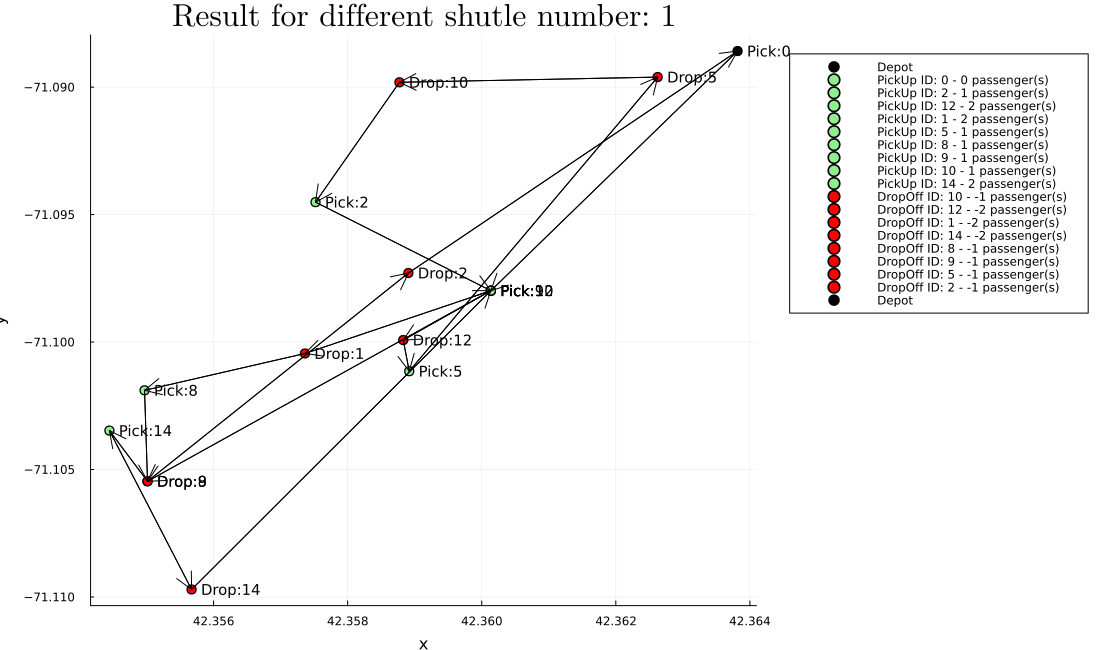

In [ ]:
plots[1]

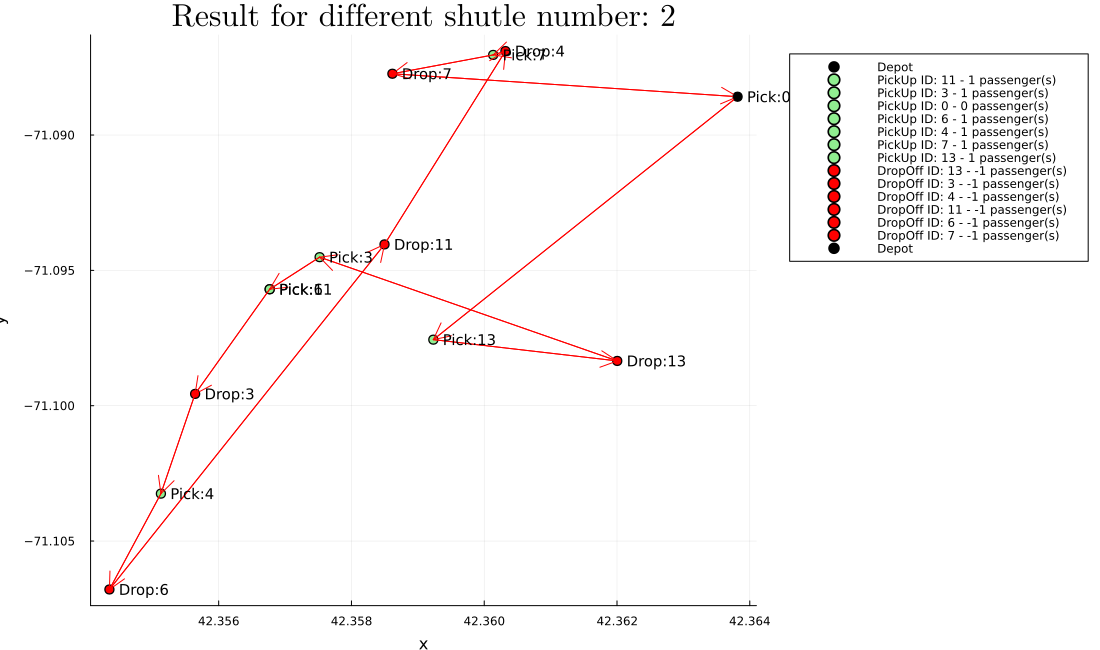

In [ ]:
plots[2]

In [ ]:
# get the indices all the elements equal to 1 in x_values
vals = [findall(x_values[:, :, i] .== 1)[1] for i=1:K]
vals

2-element Vector{CartesianIndex{2}}:
 CartesianIndex(1, 2)
 CartesianIndex(28, 4)